In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import matplotlib.patches as mpatches
from dataclasses import dataclass, field, replace

# -------------------------------
# CONFIGURAZIONE PIPELINE
# -------------------------------
@dataclass
class PipelineConfig:
    # Enhancement
    clahe_clip: float = 3.0
    clahe_tile_grid: tuple = (8, 8)
    use_gabor: bool = True
    gabor_ksize: int = 21
    gabor_sigma: float = 4.0
    gabor_lambd: float = 10.0
    gabor_gamma: float = 0.5
    gabor_thetas: np.ndarray = field(default=None)

    # Mask
    mask_block_size: int = 16
    mask_thresh: float = 0.0005

    # Binarization
    bin_block_size: int = 25
    bin_C: int = 8

    # Thinning
    thinning_type: str = "zhang-suen"

    # Orientation
    orient_block_size: int = 16

    # Minutiae extraction
    border_margin: int = 16
    min_distance: int = 5
    local_radius: int = 8
    min_local_density: int = 3

In [2]:
# -------------------------------
# LOG UTILITY
# -------------------------------
LOG_ENABLED = False  # Flag globale per abilitare/disabilitare i log

def log(msg: str, level: str = "INFO", timestamp: bool = True) -> None:
    """
    Stampa messaggi di log colorati e formattati per monitorare l'esecuzione della pipeline.

    Args:
        msg (str): Messaggio da stampare.
        level (str, optional): Livello del log. Può essere uno tra:
            - "INFO": informazioni generiche (azzurro)
            - "STEP": passo principale della pipeline (verde)
            - "DEBUG": messaggi di debug o dettagli tecnici (grigio)
            - "WARN": avvisi o situazioni potenzialmente anomale (giallo)
            - "ERROR": errori gravi (rosso)
        timestamp (bool, optional): Se True, antepone l'orario al messaggio.
            Default a True.

    Returns:
        None

    Example:
        >>> log("Caricamento completato", level="STEP")
        [12:45:02] [STEP] Caricamento completato
    """
    if not LOG_ENABLED:
        return

    colors = {
        "INFO": "\033[94m",     # blu
        "STEP": "\033[92m",     # verde
        "DEBUG": "\033[90m",    # grigio
        "WARN": "\033[93m",     # giallo
        "ERROR": "\033[91m"     # rosso
    }
    reset = "\033[0m"
    prefix = f"[{level}]"
    if timestamp:
        t = time.strftime("%H:%M:%S")
        prefix = f"[{t}] {prefix}"
    print(f"{colors.get(level, '')}{prefix} {msg}{reset}")


In [3]:
# -------------------------------
# VISUALIZZAZIONE
# -------------------------------
def show_stages(images, titles, cols=3):
    """
    Mostra una griglia di immagini con titoli.

    Args:
        images (list of np.ndarray): Lista delle immagini da mostrare.
        titles (list of str): Lista dei titoli corrispondenti.
        cols (int): Numero di colonne nella griglia.
    """
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=(4*cols, 3*rows))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        if img is None:
            plt.title(title); plt.axis('off'); continue
        plt.imshow(img if len(img.shape)==2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                   cmap='gray' if len(img.shape)==2 else None)
        plt.title(title); plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
# -------------------------------
# PREPROCESSING
# -------------------------------
def enhance_contrast(
    image: np.ndarray,
    clipLimit: float = 3.0,
    tileGridSize: tuple[int, int] = (8, 8)
) -> np.ndarray:
    """
    Migliora il contrasto dell'immagine tramite il metodo CLAHE (Contrast Limited Adaptive Histogram Equalization).

    CLAHE divide l'immagine in regioni più piccole (tiles) e applica l'equalizzazione
    dell'istogramma in modo locale, limitando l’amplificazione del rumore grazie al parametro
    `clipLimit`. È particolarmente utile per le impronte digitali, dove il contrasto locale
    tra creste e valli è fondamentale per l’estrazione delle minutiae.

    Args:
        image (np.ndarray): Immagine in scala di grigi da migliorare.
        clipLimit (float, optional): Limite di contrasto per il clipping CLAHE.
            Valori più alti aumentano il contrasto ma anche il rischio di rumore.
            Default = 3.0.
        tileGridSize (tuple[int, int], optional): Dimensione (in celle) della griglia locale
            usata da CLAHE. Default = (8, 8).

    Returns:
        np.ndarray: Immagine con contrasto migliorato in formato uint8.

    Example:
        >>> enhanced = enhance_contrast(img, clipLimit=2.5)
    """
    # Assicura tipo corretto e normalizza se necessario
    img = image if image.dtype == np.uint8 else cv2.normalize(
        image, None, 0, 255, cv2.NORM_MINMAX
    ).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    out = clahe.apply(img)

    log(f"Enhancement: CLAHE applicato ({img.shape[1]}x{img.shape[0]})", "DEBUG")
    return out


def gabor_filter_bank(
    image: np.ndarray,
    ksize: int = 21,
    sigma: float = 4.0,
    lambd: float = 10.0,
    gamma: float = 0.5,
    thetas: np.ndarray | None = None,
    combine_mode: str = "max"
) -> np.ndarray:
    """
    Applica un banco di filtri Gabor per enfatizzare le strutture orientate (creste) dell’impronta digitale.

    I filtri di Gabor rispondono selettivamente a specifiche frequenze spaziali e orientamenti,
    permettendo di evidenziare le linee di cresta a diverse direzioni. È uno step chiave nel
    miglioramento della leggibilità dell'immagine prima della binarizzazione e thinning.

    Args:
        image (np.ndarray): Immagine in scala di grigi.
        ksize (int, optional): Dimensione del kernel Gabor (deve essere dispari). Default = 21.
        sigma (float, optional): Deviazione standard della gaussiana del kernel. Default = 4.0.
        lambd (float, optional): Lunghezza d’onda della componente sinusoidale. Default = 10.0.
        gamma (float, optional): Rapporto di forma (aspect ratio) del kernel. Default = 0.5.
        thetas (np.ndarray | None, optional): Array di orientamenti angolari in radianti.
            Se None, vengono usati 8 orientamenti equidistanti tra 0 e π. Default = None.
        combine_mode (str, optional): Metodo di combinazione delle risposte ai diversi orientamenti.
            - "max": prende il massimo (default, robusto)
            - "mean": media delle risposte
            - "sum": somma grezza

    Returns:
        np.ndarray: Immagine filtrata e normalizzata in scala [0, 255].

    Example:
        >>> filtered = gabor_filter_bank(img, ksize=19, sigma=3.5, combine_mode="mean")
    """
    thetas = thetas if thetas is not None else np.linspace(0, np.pi, 8, endpoint=False)
    responses = []

    for theta in thetas:
        kernel = cv2.getGaborKernel(
            (ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F
        )
        response = cv2.filter2D(image.astype(np.float32), cv2.CV_32F, kernel)
        responses.append(response)

    # Combina le risposte in base alla modalità scelta
    if combine_mode == "max":
        accum = np.maximum.reduce(responses)
    elif combine_mode == "mean":
        accum = np.mean(responses, axis=0)
    elif combine_mode == "sum":
        accum = np.sum(responses, axis=0)
    else:
        raise ValueError(f"Metodo di combinazione non riconosciuto: {combine_mode}")

    out = cv2.normalize(accum, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    log(f"Gabor: applicato su {len(thetas)} orientamenti con combinazione '{combine_mode}'", "DEBUG")
    return out


In [5]:
# -------------------------------
# MASK
# -------------------------------
def estimate_foreground_mask(
    image: np.ndarray,
    block_size: int = 32,
    thresh: float = 0.0008,
    smooth_kernel: int = 15
) -> np.ndarray:
    """
    Stima la maschera di primo piano (foreground) identificando le aree contenenti impronte.

    L’immagine viene suddivisa in blocchi e viene calcolata la varianza locale.
    I blocchi con varianza superiore a `thresh` vengono considerati parte del foreground.
    Questo step serve per escludere lo sfondo o le zone a basso contrasto.

    Args:
        image (np.ndarray): Immagine in scala di grigi normalizzata (uint8).
        block_size (int, optional): Dimensione del blocco per il calcolo della varianza. Default = 32.
        thresh (float, optional): Soglia minima di varianza per considerare il blocco come foreground. Default = 0.0008.
        smooth_kernel (int, optional): Dimensione del kernel per la sfocatura gaussiana
            usata per ammorbidire i bordi della maschera. Default = 15.

    Returns:
        np.ndarray: Maschera binaria (0=background, 255=foreground).

    Example:
        >>> mask = estimate_foreground_mask(img_gabor, block_size=16, thresh=0.001)
    """
    h, w = image.shape
    mask = np.zeros_like(image, dtype=np.uint8)

    # Scansione a blocchi per la varianza locale
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            block = image[y:y+block_size, x:x+block_size]
            if block.size == 0:
                continue
            if np.var(block) > thresh * 255**2:
                mask[y:y+block_size, x:x+block_size] = 255

    # Liscia la maschera per ridurre artefatti a blocchi
    mask = cv2.GaussianBlur(mask, (smooth_kernel, smooth_kernel), 0)
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    log(f"Mask stimata con blocchi {block_size}x{block_size} e soglia {thresh}", "DEBUG")
    return mask_bin


In [6]:
# -------------------------------
# BINARIZZAZIONE
# -------------------------------
def adaptive_binarization(
    image: np.ndarray,
    method: str = "gaussian",
    block_size: int = 25,
    C: int = 10
) -> np.ndarray:
    """
    Applica la binarizzazione adattiva per evidenziare le creste dell’impronta.

    Utilizza la soglia adattiva (mean o gaussian) per gestire variazioni di luminosità
    locali, mantenendo visibili i dettagli anche in condizioni di illuminazione non uniforme.

    Args:
        image (np.ndarray): Immagine in scala di grigi (uint8).
        method (str, optional): Metodo di soglia:
            - "mean": media locale
            - "gaussian": media pesata da una gaussiana (default)
        block_size (int, optional): Dimensione del blocco locale. Deve essere dispari. Default = 25.
        C (int, optional): Costante sottratta alla media locale per la soglia. Default = 10.

    Returns:
        np.ndarray: Immagine binaria (0 o 255).

    Example:
        >>> bin_img = adaptive_binarization(img_gabor, method="mean", C=8)
    """
    if method.lower() == "gaussian":
        bin_img = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C
        )
    elif method.lower() == "mean":
        bin_img = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C
        )
    else:
        raise ValueError(f"Metodo di binarizzazione non riconosciuto: '{method}'")

    log(f"Binarizzazione adattiva completata (metodo={method}, block={block_size}, C={C})", "DEBUG")
    return bin_img

In [7]:
# -------------------------------
# THINNING
# -------------------------------
def thinning(binary_image: np.ndarray, method: str = "zhang_suen") -> np.ndarray:
    """
    Applica un'operazione di thinning (scheletrizzazione) per ridurre le creste a spessore singolo.

    Questa fase è essenziale per la corretta identificazione delle minutiae (terminazioni e biforcazioni).
    Supporta sia l'algoritmo Zhang-Suen (standard per impronte) che Guo-Hall.

    Args:
        binary_image (np.ndarray): Immagine binaria (0=sfondo, 255=creste).
        method (str, optional): Algoritmo di thinning:
            - "zhang_suen": algoritmo classico iterativo (default)
            - "guo_hall": variante più veloce ma leggermente meno precisa

    Returns:
        np.ndarray: Immagine scheletrizzata (0 o 255).

    Example:
        >>> skel = thinning(bin_img, method="guo_hall")
    """
    bin_img = ((binary_image > 0).astype(np.uint8)) * 255
    if method == "zhang_suen":
        skel = cv2.ximgproc.thinning(bin_img, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    elif method == "guo_hall":
        skel = cv2.ximgproc.thinning(bin_img, thinningType=cv2.ximgproc.THINNING_GUOHALL)
    else:
        raise ValueError(f"Metodo di thinning non riconosciuto: '{method}'")

    log(f"Thinning eseguito con metodo '{method}'", "DEBUG")
    return skel

In [8]:
# -------------------------------
# ORIENTATION FIELD
# -------------------------------
def compute_orientation_field(
    image: np.ndarray,
    block_size: int = 16,
    smooth: bool = True,
    smooth_kernel: int = 5
) -> np.ndarray:
    """
    Calcola il campo di orientazione locale delle creste di un'impronta digitale.

    L'orientazione viene stimata tramite i gradienti di Sobel (dx, dy) e mediata
    all'interno di blocchi di dimensione `block_size`. Il risultato è una mappa
    bidimensionale di angoli in radianti, che descrive la direzione media
    delle creste in ogni regione.

    Formula di base:
        θ(x, y) = 0.5 * arctan2(2 * Σ(Gx * Gy), Σ(Gx² - Gy²))

    Args:
        image (np.ndarray): Immagine in scala di grigi (uint8 o float) preferibilmente filtrata (es. con Gabor).
        block_size (int, optional): Dimensione dei blocchi locali su cui viene calcolata la direzione media. Default = 16.
        smooth (bool, optional): Se True, applica uno smoothing gaussiano al campo orientazioni per ridurre discontinuità. Default = True.
        smooth_kernel (int, optional): Dimensione del kernel di smoothing (solo se `smooth=True`). Default = 5.

    Returns:
        np.ndarray: Matrice di angoli in radianti di forma (H/block_size, W/block_size).

    Example:
        >>> orient = compute_orientation_field(img_gabor, block_size=16)
        >>> print(orient.shape)  # -> (rows, cols)
    """
    if block_size <= 0:
        raise ValueError("block_size deve essere maggiore di 0.")

    img = image.astype(np.float64)
    h, w = img.shape

    # Calcolo dei gradienti orizzontali e verticali
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    nrows, ncols = h // block_size, w // block_size
    angles = np.zeros((nrows, ncols), dtype=np.float32)

    # Stima direzione media per blocco
    for i in range(nrows):
        for j in range(ncols):
            bx = gx[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            by = gy[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            if bx.size == 0 or by.size == 0:
                continue
            Vx = 2 * np.sum(bx * by)
            Vy = np.sum(bx**2 - by**2)
            angles[i, j] = 0.5 * np.arctan2(Vx, Vy)

    # Smoothing opzionale del campo direzioni (filtraggio circolare)
    if smooth:
        sin2θ = np.sin(2 * angles)
        cos2θ = np.cos(2 * angles)
        sin2θ = cv2.GaussianBlur(sin2θ, (smooth_kernel, smooth_kernel), 0)
        cos2θ = cv2.GaussianBlur(cos2θ, (smooth_kernel, smooth_kernel), 0)
        angles = 0.5 * np.arctan2(sin2θ, cos2θ)

    log(f"Orientation field calcolato su griglia {nrows}x{ncols} (block={block_size}, smooth={smooth})", "DEBUG")
    return angles


def orientation_at_pixel(
    angles: np.ndarray,
    x: int,
    y: int,
    block_size: int = 16
) -> float:
    """
    Restituisce l'orientazione locale più vicina a un pixel dato.

    Args:
        angles (np.ndarray): Campo delle orientazioni (in radianti) ottenuto da `compute_orientation_field`.
        x (int): Coordinata orizzontale del pixel.
        y (int): Coordinata verticale del pixel.
        block_size (int, optional): Dimensione del blocco usata nella stima dell’orientazione. Default = 16.

    Returns:
        float: Orientazione in radianti corrispondente al blocco più vicino.

    Example:
        >>> theta = orientation_at_pixel(orient, x=120, y=80, block_size=16)
        >>> print(round(theta, 2))
    """
    i = np.clip(int(y // block_size), 0, angles.shape[0] - 1)
    j = np.clip(int(x // block_size), 0, angles.shape[1] - 1)
    return float(angles[i, j])


In [9]:
# -------------------------------
# MINUTIAE EXTRACTION
# -------------------------------
def get_8_neighbors(bin_skel: np.ndarray, x: int, y: int) -> list[int]:
    """
    Restituisce la lista dei vicini 8-connessi di un pixel in ordine orario.

    L’ordine dei vicini parte da Est (x+1, y) e procede in senso orario:
    E, SE, S, SO, O, NO, N, NE.

    Args:
        bin_skel (np.ndarray): Immagine binaria scheletrizzata (0/1 o 0/255).
        x (int): Coordinata X del pixel (colonna).
        y (int): Coordinata Y del pixel (riga).

    Returns:
        list[int]: Lista di valori binari (0 o 1) dei vicini.
    """
    h, w = bin_skel.shape
    coords = [
        (x + 1, y), (x + 1, y + 1), (x, y + 1), (x - 1, y + 1),
        (x - 1, y), (x - 1, y - 1), (x, y - 1), (x + 1, y - 1)
    ]
    return [
        1 if 0 <= cx < w and 0 <= cy < h and bin_skel[cy, cx] > 0 else 0
        for cx, cy in coords
    ]


def crossing_number_at(neighbors: list[int]) -> float:
    """
    Calcola il Crossing Number (CN) per classificare il tipo di minutia.

    Il CN misura il numero di transizioni 0→1 nei pixel vicini disposti
    in senso orario. Valori tipici:
      - CN = 1 → Ridge Ending
      - CN = 3 → Ridge Bifurcation

    Formula:
        CN = 0.5 * Σ |P(i) - P(i+1)|, i = 1..8

    Args:
        neighbors (list[int]): Lista binaria (lunghezza 8) dei vicini.

    Returns:
        float: Valore del Crossing Number.
    """
    return 0.5 * sum(abs(neighbors[k] - neighbors[(k + 1) % 8]) for k in range(8))


def extract_minutiae_from_skeleton(
    skel: np.ndarray,
    mask: np.ndarray | None = None,
    border_margin: int = 5,
    min_distance: int = 5,
    orientation_field: np.ndarray | None = None,
    block_size: int = 16,
    use_orientation: bool = True,
    valid_types: tuple[str, ...] = ("ending", "bifurcation")
) -> list[dict]:
    """
    Estrae le minutiae (terminazioni e biforcazioni) dallo skeleton binario.

    Analizza ogni pixel attivo nello scheletro, calcola il Crossing Number
    e determina se il punto è una **ridge ending** o una **bifurcation**.
    È possibile filtrare punti ai bordi e opzionalmente associare
    l’orientazione locale derivata dal campo di orientazione.

    Args:
        skel (np.ndarray): Immagine binaria scheletrizzata (0/1 o 0/255).
        mask (np.ndarray | None): Maschera binaria per limitare l’analisi al foreground.
        border_margin (int, optional): Margine in pixel per escludere minutiae vicino ai bordi. Default = 5.
        min_distance (int, optional): Distanza minima tra minutiae per evitare duplicati (non ancora enforced). Default = 5.
        orientation_field (np.ndarray | None): Campo di orientazioni (rad) ottenuto da `compute_orientation_field`. Default = None.
        block_size (int, optional): Dimensione blocco per interpolare orientazione. Default = 16.
        use_orientation (bool, optional): Se True, aggiunge orientazione locale alla minutia. Default = True.
        valid_types (tuple[str], optional): Tipi di minutiae da considerare. Default = ("ending", "bifurcation").

    Returns:
        list[dict]: Lista di minutiae, ognuna come:
            {
                "x": int,             # coordinata X (colonna)
                "y": int,             # coordinata Y (riga)
                "type": str,          # "ending" o "bifurcation"
                "cn": float,          # Crossing Number grezzo
                "orientation": float  # (opzionale, radianti)
            }

    Example:
        >>> minutiae = extract_minutiae_from_skeleton(skel, mask, orientation_field=orient)
        >>> len(minutiae)
        42
    """
    if skel is None or skel.size == 0:
        raise ValueError("L'immagine skeleton è vuota o None.")

    sk = (skel > 0).astype(np.uint8)
    h, w = sk.shape
    minutiae = []

    for y, x in zip(*np.where(sk == 1)):
        # Esclusione dei bordi
        if (
            x < border_margin or y < border_margin or
            x >= w - border_margin or y >= h - border_margin
        ):
            continue

        # Esclusione regioni mascherate
        if mask is not None and mask[y, x] == 0:
            continue

        # Calcolo Crossing Number
        cn = crossing_number_at(get_8_neighbors(sk, x, y))
        typ = (
            "ending" if round(cn) == 1 else
            "bifurcation" if round(cn) == 3 else
            None
        )

        if typ not in valid_types or typ is None:
            continue

        # Orientazione locale opzionale
        orientation = (
            orientation_at_pixel(orientation_field, x, y, block_size)
            if (use_orientation and orientation_field is not None)
            else None
        )

        minutiae.append({
            "x": x,
            "y": y,
            "type": typ,
            "cn": cn,
            "orientation": orientation
        })

    log(f"Minutiae estratte: {len(minutiae)} (types={valid_types}, border_margin={border_margin})", "DEBUG")
    return minutiae


In [ ]:
# -------------------------------
# FILTRAGGI MINUTIAE
# -------------------------------
def filter_minutiae_bound(
    minutiae: list[dict], 
    skeleton: np.ndarray, 
    border_margin: int = 16
) -> list[dict]:
    """
    Rimuove le minutiae troppo vicine ai bordi dell'immagine.

    Args:
        minutiae (list[dict]): Lista di minutiae {'x','y','type',...}.
        skeleton (np.ndarray): Immagine skeleton usata per ottenere dimensioni.
        border_margin (int): Numero di pixel da considerare come margine da escludere.

    Returns:
        list[dict]: Lista filtrata.
    """
    h, w = skeleton.shape[:2]
    filtered = [m for m in minutiae 
                if border_margin <= m['x'] < w - border_margin 
                and border_margin <= m['y'] < h - border_margin]
    log(f"Minutiae filtrate ai bordi: {len(filtered)} / {len(minutiae)}", "INFO")
    return filtered


def filter_minutiae(
    minutiae: list[dict],
    skeleton: np.ndarray,
    border_margin: int = 16,
    min_distance: int = 5,
    local_radius: int = 8,
    min_local_density: int = 3
) -> list[dict]:
    """
    Filtra le minutiae in modo avanzato:
    1) rimuove quelle vicino ai bordi,
    2) rimuove quelle in zone a bassa densità di skeleton,
    3) rimuove punti troppo vicini, privilegiando biforcazioni.

    Args:
        minutiae (list[dict]): Lista iniziale di minutiae.
        skeleton (np.ndarray): Immagine skeleton (0/1 o 0/255).
        border_margin (int): Margine bordo da escludere.
        min_distance (int): Distanza minima fra minutiae.
        local_radius (int): Raggio per valutare densità locale dello skeleton.
        min_local_density (int): Numero minimo di pixel attivi richiesto nel raggio locale.

    Returns:
        list[dict]: Lista filtrata di minutiae.
    """
    h, w = skeleton.shape[:2]
    filtered = []

    for m in minutiae:
        x, y = int(m['x']), int(m['y'])

        # 1) Bordo
        if x < border_margin or x >= w - border_margin or y < border_margin or y >= h - border_margin:
            continue

        # 2) Densità locale dello skeleton
        y0, y1 = max(0, y - local_radius), min(h, y + local_radius + 1)
        x0, x1 = max(0, x - local_radius), min(w, x + local_radius + 1)
        local_count = np.count_nonzero(skeleton[y0:y1, x0:x1])
        if local_count < min_local_density:
            continue

        # 3) Distanza minima dalle minutiae già selezionate
        too_close = False
        for other in filtered[:]:  # copia per sicurezza
            dist = np.hypot(x - other['x'], y - other['y'])
            if dist < min_distance:
                # Priorità: mantieni biforcazioni
                if m['type'] == 'bifurcation' and other['type'] == 'ending':
                    filtered.remove(other)
                elif m['type'] == 'ending' and other['type'] == 'bifurcation':
                    too_close = True
                    break
                else:
                    too_close = True
                    break
        if too_close:
            continue

        filtered.append(m)

    log(f"Minutiae filtrate avanzate: {len(filtered)} / {len(minutiae)}", "INFO")
    return filtered


In [ ]:
# -------------------------------
# VISUALIZZAZIONE MINUTIAE
# -------------------------------
def plot_minutiae_overlay(
    image: np.ndarray, 
    skel: np.ndarray, 
    minutiae: list[dict], 
    figsize=(8, 10)
) -> np.ndarray:
    """
    Crea un'immagine RGB con lo skeleton in evidenza e le minutiae sovrapposte.

    Comportamento:
    - Converte l'immagine in RGB.
    - Colora i pixel dello skeleton con una tinta leggera.
    - Disegna cerchi per ogni minutia (verde = ending, rosso = bifurcation).
    - Aggiunge il simbolo 'E' o 'B' vicino alla minutia.
    - Se è disponibile l'orientazione, disegna una freccia che indica la direzione.

    Args:
        image (np.ndarray): Immagine grayscale originale.
        skel (np.ndarray): Immagine scheletrizzata binaria (pixel >0 = skeleton).
        minutiae (list[dict]): Lista minutiae con chiavi {'x','y','type','orientation'(opz)}.
        figsize (tuple): Dimensione suggerita per il plot (non usata nel return).

    Returns:
        np.ndarray: Immagine RGB con overlay (dtype=uint8, valori 0-255).
    """
    # Assicura che l'immagine sia grayscale
    base = image
    if len(base.shape) == 3:
        base_gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    else:
        base_gray = base

    # Conversione in RGB
    img_rgb = cv2.cvtColor(base_gray, cv2.COLOR_GRAY2BGR)

    # Colorazione dello skeleton (leggero grigio)
    skeleton_mask = (skel > 0)
    img_rgb[skeleton_mask] = (180, 180, 180)

    # Disegna le minutiae
    for m in minutiae:
        x, y = int(m['x']), int(m['y'])
        color = (0, 255, 0) if m['type'] == "ending" else (0, 0, 255)

        # Cerchio per minutia
        cv2.circle(img_rgb, (x, y), 4, color, thickness=1, lineType=cv2.LINE_AA)

        # Etichetta testuale
        label = 'E' if m['type'] == "ending" else 'B'
        cv2.putText(img_rgb, label, (x + 6, y - 6), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1, cv2.LINE_AA)

        # Orientazione (freccia) se presente
        if m.get('orientation') is not None:
            ang = float(m['orientation'])
            dx = int(14 * np.cos(ang))
            dy = int(14 * np.sin(ang))
            cv2.arrowedLine(img_rgb, (x, y), (x + dx, y + dy), (255, 255, 0), 1, tipLength=0.25)

    return img_rgb


In [ ]:
# -------------------------------
# PIPELINE COMPLETA PARAMETRIZZATA
# -------------------------------
def demo_pipeline(image_path,
                  config: PipelineConfig = None,
                  verbose: bool = True,
                  **override_kwargs):
    """
    Esegue la pipeline completa di preprocessing, skeletonization e estrazione/filtering delle minutiae.

    Parametrizzazione:
        - Puoi passare un'istanza PipelineConfig con tutti i parametri.
        - In alternativa puoi passare kwargs che sovrascrivono i valori del config,
          es: demo_pipeline(path, clahe_clip=4.0, gabor_ksize=31)

    Steps:
        1) Caricamento e normalizzazione immagine
        2) Enhancement (CLAHE + opzionale Gabor)
        3) Stima mask foreground
        4) Binarizzazione adattiva
        5) Masking + Thinning
        6) Calcolo campo orientazione
        7) Estrazione minutiae (raw) e due stadi di filtraggio
        8) Visualizzazioni e summary

    Args:
        image_path (str | Path): Percorso immagine.
        config (PipelineConfig | None): Config completa (se None usa valori di default).
        verbose (bool): Se True stampa log e mostra figure.
        **override_kwargs: singoli parametri da sovrascrivere in config.

    Returns:
        dict: {
            "skeleton": np.ndarray,
            "mask": np.ndarray,
            "minutiae_raw": list,
            "minutiae_after_border": list,
            "minutiae_clean": list,
            "orientation": np.ndarray,
            "timings": dict,
            "metrics": dict
        }
    """
    # Merge config with overrides
    cfg = config or PipelineConfig()
    if override_kwargs:
        # crea una copia modificata senza mutare l'originale
        cfg = replace(cfg, **{k: override_kwargs[k] for k in override_kwargs if hasattr(cfg, k)})

    # Timers
    timers = {}
    log(f"--- ELABORAZIONE: {image_path} ---", "STEP")
    t_start = time.time()

    # Caricamento
    t0 = time.time()
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        log("Errore: immagine non caricata", "ERROR")
        return None
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    timers['load'] = time.time() - t0
    log(f"Immagine caricata ({img.shape[1]}x{img.shape[0]})", "INFO")

    # Enhancement CLAHE
    t1 = time.time()
    img_clahe = enhance_contrast(img, clipLimit=cfg.clahe_clip, tileGridSize=cfg.clahe_tile_grid)
    timers['clahe'] = time.time() - t1

    # Gabor
    if cfg.use_gabor:
        t2 = time.time()
        img_gabor = gabor_filter_bank(img_clahe,
                                      ksize=cfg.gabor_ksize,
                                      sigma=cfg.gabor_sigma,
                                      lambd=cfg.gabor_lambd,
                                      gamma=cfg.gabor_gamma,
                                      thetas=cfg.gabor_thetas)
        timers['gabor'] = time.time() - t2
    else:
        img_gabor = img_clahe
        timers['gabor'] = 0.0

    # Mask
    t3 = time.time()
    mask = estimate_foreground_mask(img_gabor, block_size=cfg.mask_block_size, thresh=cfg.mask_thresh)
    timers['mask'] = time.time() - t3

    # Binarizzazione
    t4 = time.time()
    img_bin = adaptive_binarization(img_gabor, block_size=cfg.bin_block_size, C=cfg.bin_C)
    timers['binarization'] = time.time() - t4

    # Applica mask e thinning
    t5 = time.time()
    img_bin_masked = cv2.bitwise_and(img_bin, mask)
    skeleton = thinning(img_bin_masked, method='zhang_suen')
    timers['thinning'] = time.time() - t5

    # Orientation field
    t6 = time.time()
    orientation = compute_orientation_field(img_gabor, block_size=cfg.orient_block_size)
    timers['orientation'] = time.time() - t6

    # Estrazione minutiae
    t7 = time.time()
    minutiae_raw = extract_minutiae_from_skeleton(skeleton, mask=mask,
                                                  border_margin=cfg.border_margin,
                                                  min_distance=cfg.min_distance,
                                                  orientation_field=orientation,
                                                  block_size=cfg.orient_block_size)
    timers['minutiae_raw'] = time.time() - t7

    # Primo filtro: bordo
    t8 = time.time()
    minutiae_after_border = filter_minutiae_bound(minutiae_raw, skeleton, border_margin=cfg.border_margin * 3)
    timers['filter_border'] = time.time() - t8

    # Secondo filtro: avanzato
    t9 = time.time()
    minutiae_clean = filter_minutiae(minutiae_after_border, skeleton,
                                     border_margin=cfg.border_margin,
                                     min_distance=cfg.min_distance,
                                     local_radius=cfg.local_radius,
                                     min_local_density=cfg.min_local_density)
    timers['filter_advanced'] = time.time() - t9

    total_time = time.time() - t_start
    timers['total'] = total_time
    log(f"Pipeline completata in {total_time:.2f}s", "STEP")

    # Metrics summary
    metrics = {
        "img_shape": img.shape,
        "n_minutiae_raw": len(minutiae_raw),
        "n_minutiae_after_border": len(minutiae_after_border),
        "n_minutiae_clean": len(minutiae_clean),
        "foreground_pct": float(np.mean(mask > 0) * 100)
    }

    # Visualizzazioni (solo se verbose)
    if verbose:
        # Workflow immagini principali
        log("Mostro workflow dei passaggi principali...", "INFO")
        show_stages([img, img_clahe, img_gabor, mask, img_bin_masked, skeleton],
                    ["Originale", "CLAHE", "Gabor" if cfg.use_gabor else "No Gabor",
                     "Mask", "Binary+Mask", "Skeleton"], cols=3)

        # Storico filtraggio minutiae con overlay
        log("Mostro storico filtraggio delle minutiae...", "INFO")
        stages = [minutiae_raw, minutiae_after_border, minutiae_clean]
        titles = ["Minutiae Raw", "Dopo filtro bordo", "Dopo filtro avanzato"]
        colors = {"ending": (0, 255, 0), "bifurcation": (0, 0, 255)}

        plt.figure(figsize=(18, 6))
        for i, (stage, title) in enumerate(zip(stages, titles)):
            ax = plt.subplot(1, 3, i + 1)
            overlay = plot_minutiae_overlay(img, skeleton, stage)
            ax.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{title} ({len(stage)})")
            ax.axis('off')

        # Legenda esterna
        patch_ending = mpatches.Patch(color=np.array(colors["ending"])[::-1] / 255, label="Ending")
        patch_bifurcation = mpatches.Patch(color=np.array(colors["bifurcation"])[::-1] / 255, label="Bifurcation")
        plt.legend(handles=[patch_ending, patch_bifurcation], loc='upper right', bbox_to_anchor=(1.05, 1.0))
        plt.tight_layout()
        plt.show()

        # Tabella sommario tempi
        log("Tempi (s) per step: " + ", ".join(f"{k}:{v:.3f}" for k, v in timers.items()), "INFO")
        # Metrics quick print
        log(f"Metrics: {metrics}", "INFO")

    return {
        "skeleton": skeleton,
        "mask": mask,
        "minutiae_raw": minutiae_raw,
        "minutiae_after_border": minutiae_after_border,
        "minutiae_clean": minutiae_clean,
        "orientation": orientation,
        "timings": timers,
        "metrics": metrics
    }


In [ ]:
TARGET_MINUTIAE = 25

def objective(trial):
    sample_image = "/Users/giovanni02/Desktop/UNIKORE/multimodal_biometric_fingerprints_palms/dataset/FingerprintV5(BMP)/000/L/000_L0_0.bmp"

    cfg = PipelineConfig(
        clahe_clip=trial.suggest_float("clahe_clip", 1.0, 5.0),
        gabor_ksize=trial.suggest_int("gabor_ksize", 11, 31, step=2),
        gabor_sigma=trial.suggest_float("gabor_sigma", 1.0, 10.0),
        gabor_lambd=trial.suggest_float("gabor_lambd", 5.0, 15.0),
        gabor_gamma=trial.suggest_float("gabor_gamma", 0.1, 1.0),
        mask_block_size=trial.suggest_int("mask_block_size", 8, 32),
        mask_thresh=trial.suggest_float("mask_thresh", 0.001, 0.02),
        bin_block_size=trial.suggest_int("bin_block_size", 3, 31, step=2),
        bin_C=trial.suggest_int("bin_C", 1, 15),
        orient_block_size=trial.suggest_int("orient_block_size", 8, 32),
        border_margin=trial.suggest_int("border_margin", 5, 35),
        min_distance=trial.suggest_int("min_distance", 2, 10),
        local_radius=trial.suggest_int("local_radius", 2, 15),
        min_local_density=trial.suggest_int("min_local_density", 1, 5),
        use_gabor=True,
    )

    result = demo_pipeline(sample_image, config=cfg, verbose=False)
    n_minutiae = result['metrics']['n_minutiae_clean']
    fg_pct = result['metrics']['foreground_pct']

    if n_minutiae == 0 or fg_pct < 5:
        return -1000

    score = -abs(n_minutiae - TARGET_MINUTIAE)
    score += 0.1 * result['metrics'].get('quality_score', 0)
    return score

/opt/miniconda3/envs/multimodal_biometric_transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-29 23:14:12,823] A new study created in memory with name: no-name-e6231f86-eca5-4e81-8c80-44a0539edf8f
[I 2025-10-29 23:14:13,896] Trial 0 finished with value: -600.0 and parameters: {'clahe_clip': 4.623959978700272, 'gabor_ksize': 21, 'gabor_sigma': 5.869569199910603, 'gabor_lambd': 7.113163554203065, 'gabor_gamma': 0.44135100467452565, 'mask_block_size': 29, 'mask_thresh': 0.0056932225136171015, 'bin_block_size': 9, 'bin_C': 15, 'orient_block_size': 18, 'border_margin': 13, 'min_distance': 7, 'local_radius': 2, 'min_local_density': 5}. Best is trial 0 with value: -600.0.
[I 2025-10-29 23:14:13,976] Trial 1 finished with value: -76.0 and parameters: {'clahe_clip': 2.0795931185221335, 'gabor_

Miglior configurazione trovata:
{'clahe_clip': 1.956492954008688, 'gabor_ksize': 29, 'gabor_sigma': 9.511362882060324, 'gabor_lambd': 14.14434446978962, 'gabor_gamma': 0.38485731449694704, 'mask_block_size': 8, 'mask_thresh': 0.016541160572124156, 'bin_block_size': 11, 'bin_C': 7, 'orient_block_size': 30, 'border_margin': 32, 'min_distance': 10, 'local_radius': 14, 'min_local_density': 3}
Score massimo: -1.0
[23:14:24] [STEP] --- ELABORAZIONE: /Users/giovanni02/Desktop/UNIKORE/multimodal_biometric_fingerprints_palms/dataset/FingerprintV5(BMP)/000/L/000_L0_0.bmp ---
[23:14:24] [INFO] Immagine caricata (328x356)
[23:14:24] [DEBUG] Enhancement: CLAHE applicato (328x356)
[23:14:24] [DEBUG] Gabor: applicato su 8 orientamenti con combinazione 'max'
[23:14:24] [DEBUG] Mask stimata con blocchi 8x8 e soglia 0.016541160572124156
[23:14:24] [DEBUG] Binarizzazione adattiva completata (metodo=gaussian, block=11, C=7)
[23:14:24] [DEBUG] Thinning eseguito con metodo 'zhang_suen'
[23:14:24] [DEBUG] Or

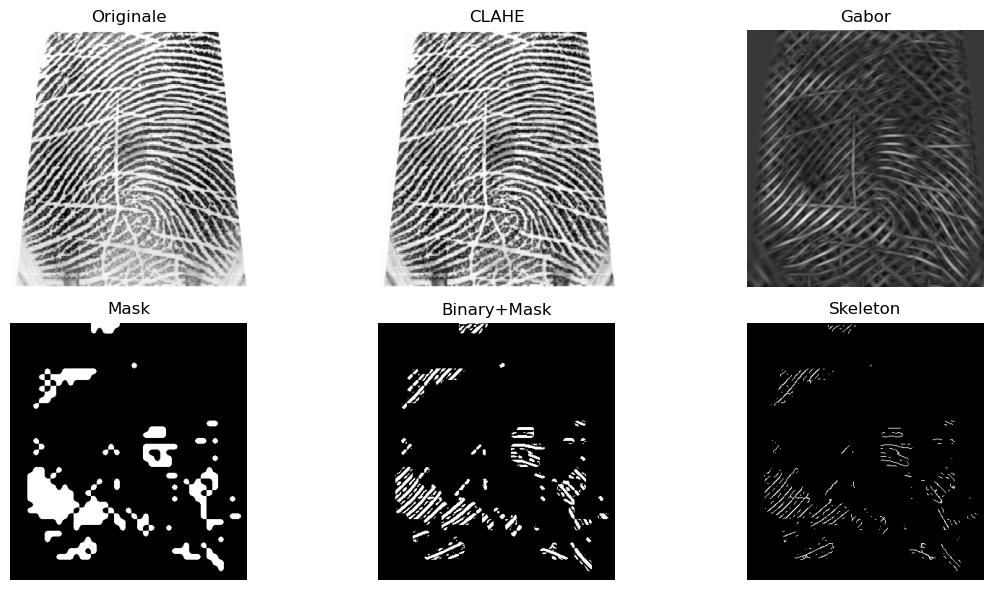

[23:14:24] [INFO] Mostro storico filtraggio delle minutiae...


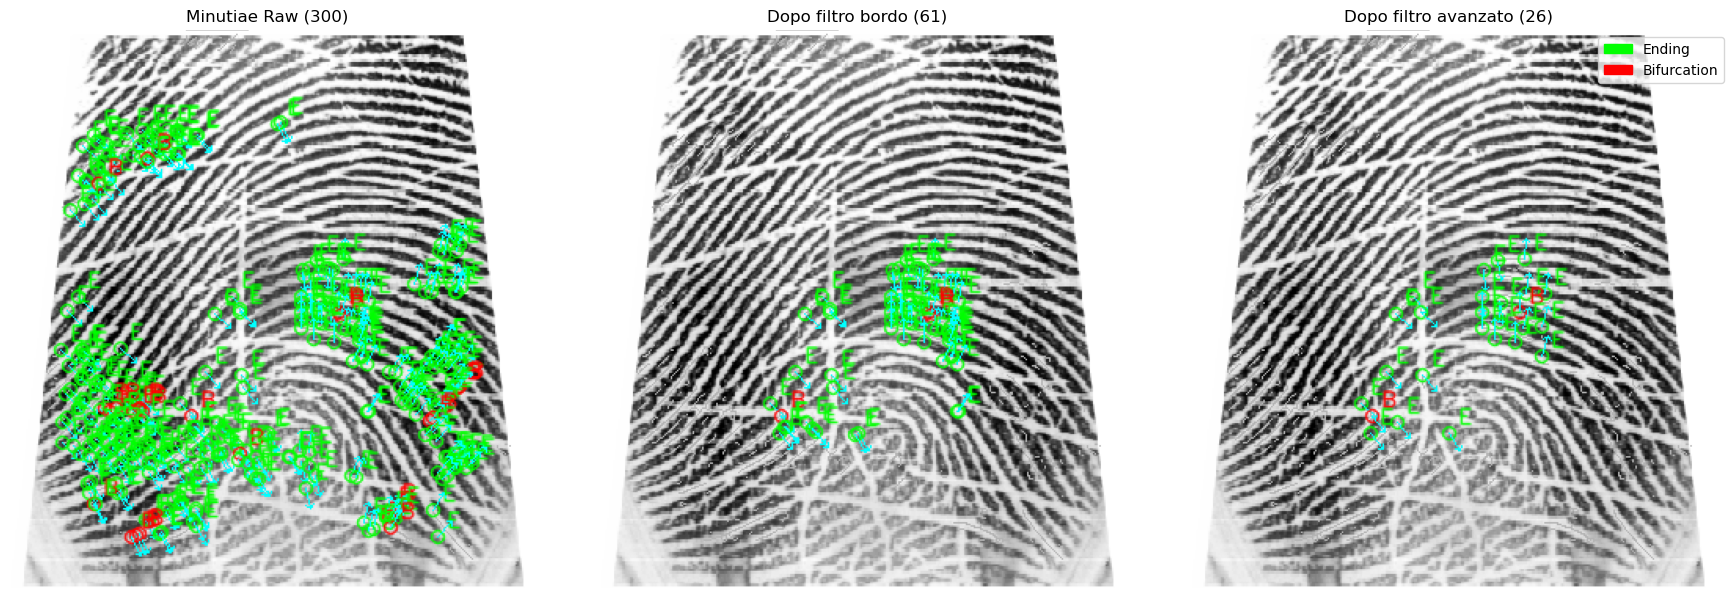

[23:14:24] [INFO] Tempi (s) per step: load:0.000, clahe:0.000, gabor:0.019, mask:0.013, binarization:0.000, thinning:0.005, orientation:0.001, minutiae_raw:0.010, filter_border:0.000, filter_advanced:0.001, total:0.050
[23:14:24] [INFO] Metrics: {'img_shape': (356, 328), 'n_minutiae_raw': 300, 'n_minutiae_after_border': 61, 'n_minutiae_clean': 26, 'foreground_pct': 11.813167991230474}


In [ ]:
# -------------------------------
# Avvio dello studio Optuna
# -------------------------------
import optuna
if __name__ == "__main__":
    sample_image = "/Users/giovanni02/Desktop/UNIKORE/multimodal_biometric_fingerprints_palms/dataset/FingerprintV5(BMP)/000/L/000_L0_0.bmp"
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)
    
    print("Miglior configurazione trovata:")
    print(study.best_trial.params)
    print("Score massimo:", study.best_value)
    LOG_ENABLED = True

    cfg = PipelineConfig(**study.best_trial.params) 
    result = demo_pipeline(sample_image, config=cfg, verbose=True) 

[08:55:56] [STEP] --- ELABORAZIONE: /Users/giovanni02/Desktop/UNIKORE/multimodal_biometric_fingerprints_palms/dataset/FingerprintV5(BMP)/000/L/000_L0_0.bmp ---
[08:55:56] [INFO] Immagine caricata (328x356)
[08:55:56] [DEBUG] Enhancement: CLAHE applicato (328x356)
[08:55:56] [DEBUG] Gabor: applicato su 8 orientamenti con combinazione 'max'
[08:55:56] [DEBUG] Mask stimata con blocchi 20x20 e soglia 0.0005
[08:55:56] [DEBUG] Binarizzazione adattiva completata (metodo=gaussian, block=25, C=8)
[08:55:56] [DEBUG] Thinning eseguito con metodo 'zhang_suen'
[08:55:56] [DEBUG] Orientation field calcolato su griglia 22x20 (block=16, smooth=True)
[08:55:56] [DEBUG] Minutiae estratte: 461 (types=('ending', 'bifurcation'), border_margin=32)
[08:55:56] [INFO] Minutiae filtrate ai bordi: 142 / 461
[08:55:56] [INFO] Minutiae filtrate avanzate: 103 / 142
[08:55:56] [STEP] Pipeline completata in 0.16s
[08:55:56] [INFO] Mostro workflow dei passaggi principali...


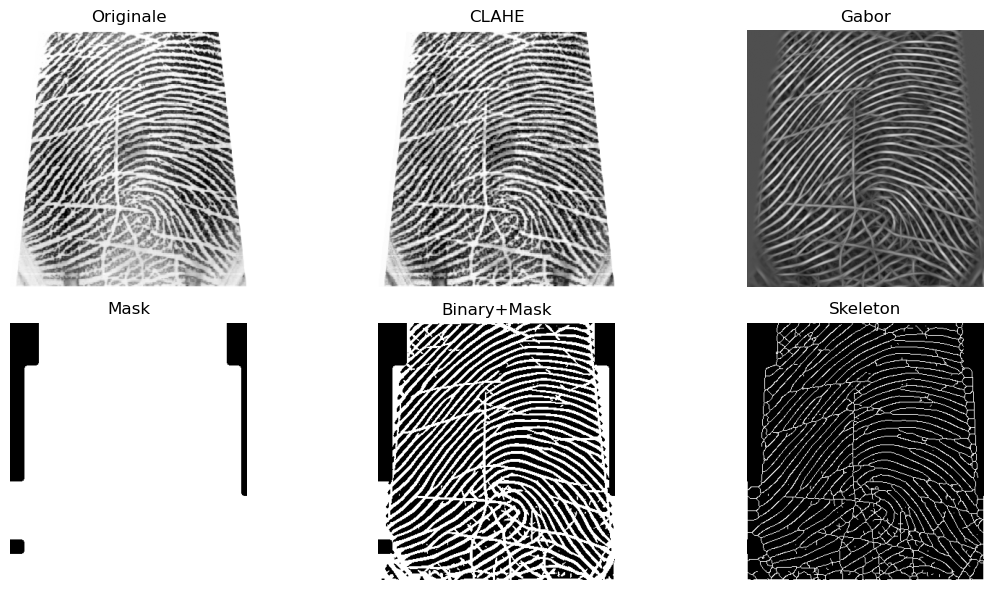

[08:55:56] [INFO] Mostro storico filtraggio delle minutiae...


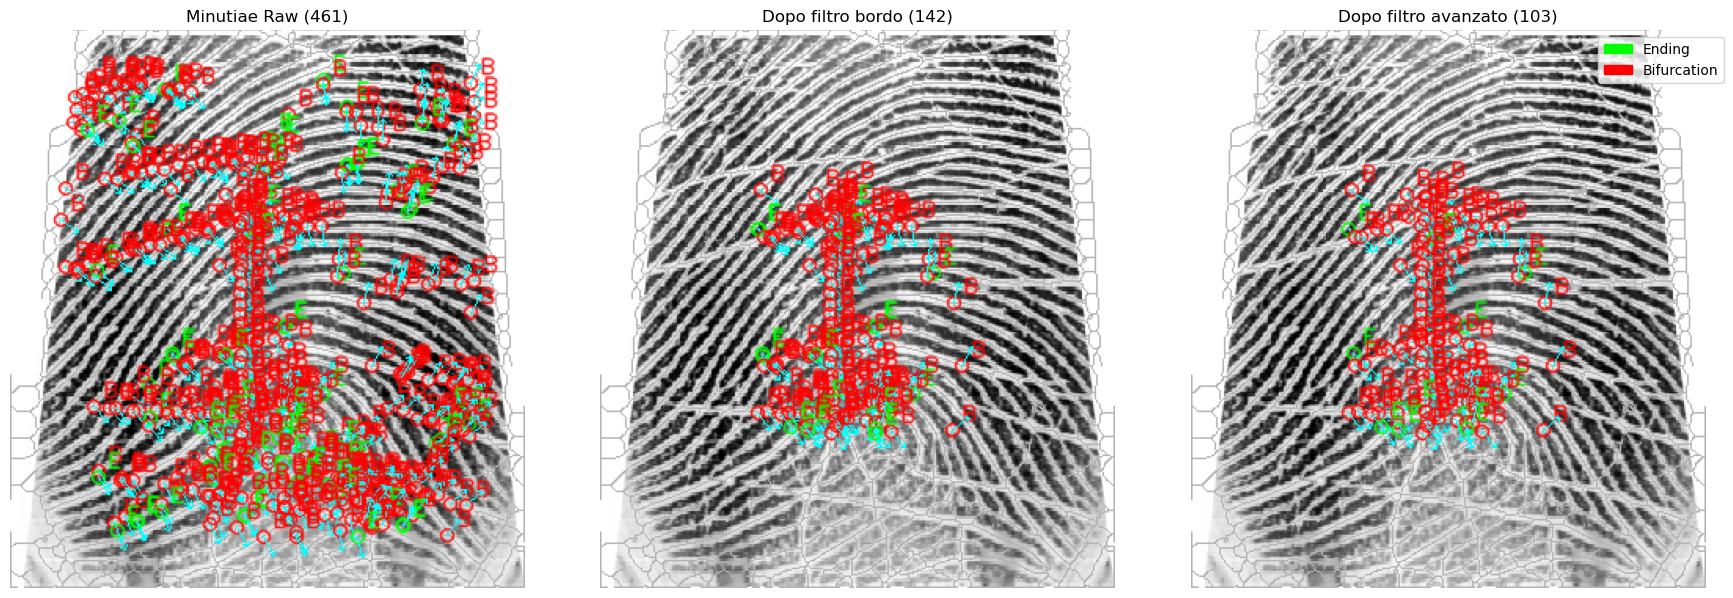

[08:55:57] [INFO] Tempi (s) per step: load:0.022, clahe:0.010, gabor:0.050, mask:0.006, binarization:0.002, thinning:0.008, orientation:0.006, minutiae_raw:0.053, filter_border:0.000, filter_advanced:0.008, total:0.165
[08:55:57] [INFO] Metrics: {'img_shape': (356, 328), 'n_minutiae_raw': 461, 'n_minutiae_after_border': 142, 'n_minutiae_clean': 103, 'foreground_pct': 92.20676897780213}
Numero di minutiae trovate: 103


In [ ]:
if __name__ == "__main__":
    # Percorso immagine di test
    sample_image = Path("/Users/giovanni02/Desktop/UNIKORE/multimodal_biometric_fingerprints_palms/dataset/FingerprintV5(BMP)/000/L/000_L0_0.bmp")

    # Parametri della pipeline
    default_params = {
        "clahe_clip": 3.0,
        "clahe_tile_grid": (8, 8),
        "use_gabor": True,
        "gabor_ksize": 21,
        "gabor_sigma": 4.0,
        "gabor_lambd": 10.0,
        "gabor_gamma": 0.5,
        "gabor_thetas": None,
        "mask_block_size": 20,
        "mask_thresh": 0.0005,
        "bin_block_size": 25,
        "bin_C": 8,
        "thinning_type": "zhang-suen",
        "orient_block_size": 16,
        "border_margin": 32,
        "min_distance": 4,
        "local_radius": 8,
        "min_local_density": 4
    }

    # Crea oggetto PipelineConfig dai parametri
    cfg = PipelineConfig(**default_params)

    # Esegui la pipeline sul sample_image
    result = demo_pipeline(sample_image, config=cfg, verbose=True)

    # Mostra metriche principali
    if result is not None:
        print("Numero di minutiae trovate:", len(result.get("minutiae_clean", [])))
    else:
        print("Pipeline fallita per questa immagine.")